# SPTcl-IRAGN Example Cluster Images Figure
## Author: Benjamin Floyd

Creates a publication figure of two example clusters near the median redshift at the extreme mass scales.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import imshow_norm, ZScaleInterval, LinearStretch, ImageNormalize
from astropy.wcs import WCS
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16})
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [2]:
# Read in the catalog
sptcl_iragn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SPTcl_IRAGN.fits')

In [3]:
# Get the median redshift of the sample
med_z = np.median(sptcl_iragn['REDSHIFT'])

# Select clusters near the median redshift
med_z_clusters = sptcl_iragn[np.abs(sptcl_iragn['REDSHIFT'] - med_z) <= 0.05]

In [4]:
# Print the SPT IDs of the most and least massive cluster in our list
# Most massive cluster: SPT-CLJ0212-4657 (SPT-SZ; IRAC obs id: SPT-CLJ0212-4656)
# Least massive cluster: SPT-CLJ2314-5554 (SPTpol 100d)
max_cluster_idx, min_cluster_idx = med_z_clusters['M500'].argmax(), med_z_clusters['M500'].argmin()
max_cluster_id = med_z_clusters['SPT_ID'][max_cluster_idx]
max_cluser_mass = med_z_clusters['M500'][max_cluster_idx]
max_cluster_z = med_z_clusters['REDSHIFT'][max_cluster_idx]
min_cluster_id = med_z_clusters['SPT_ID'][min_cluster_idx]
min_cluser_mass = med_z_clusters['M500'][min_cluster_idx]
min_cluster_z = med_z_clusters['REDSHIFT'][min_cluster_idx]
print(f"""Most massive cluster
{max_cluster_id}\tM500 = {max_cluser_mass:.2e} Msun\tz = {max_cluster_z:.2f}\trichness = {len(med_z_clusters[med_z_clusters['SPT_ID'] == max_cluster_id])}
Least massive cluster
{min_cluster_id}\tM500 = {min_cluser_mass:.2e} Msun\tz = {min_cluster_z:.2f}\trichness = {len(med_z_clusters[med_z_clusters['SPT_ID'] == min_cluster_id])}""")

Most massive cluster
SPT-CLJ0212-4657	M500 = 6.06e+14 Msun	z = 0.65	richness = 152
Least massive cluster
SPT-CLJ2314-5554	M500 = 2.18e+14 Msun	z = 0.71	richness = 167


In [5]:
# Get the catalogs for each of the clusters
spt0212_cat = sptcl_iragn[(sptcl_iragn['SPT_ID'] == f'{max_cluster_id}') & (sptcl_iragn['SELECTION_MEMBERSHIP'] >= 0.5)]
spt2314_cat = sptcl_iragn[(sptcl_iragn['SPT_ID'] == f'{min_cluster_id}') & (sptcl_iragn['SELECTION_MEMBERSHIP'] >= 0.5)]

In [6]:
# Read in the 3.6um images
spt0212_img, spt0212_hdr = fits.getdata('Data_Repository/Images/SPT/Spitzer_IRAC/SPT-SZ_2500d/I1_SPT-CLJ0212-4656_mosaic.cutout.fits', header=True)
spt2314_img, spt2314_hdr = fits.getdata('Data_Repository/Images/SPT/Spitzer_IRAC/SPTpol_100d/I1_SPT-CLJ2314-5554_mosaic.cutout.fits',header=True)

# Get WCSs
spt0212_wcs = WCS(spt0212_hdr)
spt2314_wcs = WCS(spt2314_hdr)

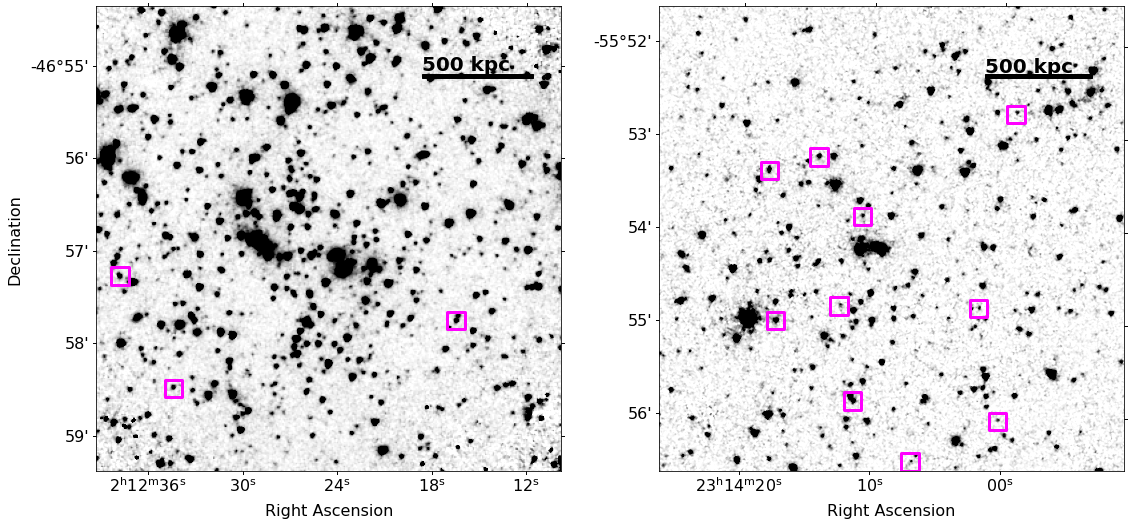

In [12]:
# Make plots
fig = plt.figure(figsize=(16, 8), tight_layout=dict(w_pad=0.5))
spt0212_ax = fig.add_subplot(121, projection=spt0212_wcs)
spt2314_ax = fig.add_subplot(122, projection=spt2314_wcs)
spt0212_ax.set(xlabel='Right Ascension', ylabel='Declination')
spt2314_ax.set(xlabel='Right Ascension', ylabel=' ')
spt2314_ax.coords[0].set_auto_axislabel(False)

# Get the normalizations for the images so we can adjust parameters
spt0212_norm = ImageNormalize(spt0212_img, interval=ZScaleInterval(), stretch=LinearStretch())
spt2314_norm = ImageNormalize(spt2314_img, interval=ZScaleInterval(), stretch=LinearStretch())

# Plot the images
imshow_norm(spt0212_img, ax=spt0212_ax, origin='lower', cmap='Greys', interval=ZScaleInterval(), stretch=LinearStretch(), vmin=spt0212_norm.vmin + 1.5e-2)
imshow_norm(spt2314_img, ax=spt2314_ax, origin='lower', cmap='Greys', interval=ZScaleInterval(), stretch=LinearStretch(), vmin=spt2314_norm.vmin + 3.75e-2)

# Plot the AGN
spt0212_ax.scatter(spt0212_cat['ALPHA_J2000'], spt0212_cat['DELTA_J2000'], marker='s', edgecolor='magenta', facecolor='none', s=300, linewidths=3, transform=spt0212_ax.get_transform('world'))
spt2314_ax.scatter(spt2314_cat['ALPHA_J2000'], spt2314_cat['DELTA_J2000'], marker='s', edgecolor='magenta', facecolor='none', s=300, linewidths=3, transform=spt2314_ax.get_transform('world'))
# # Add compasses
# compass(0.9, 0.1, size=0.1, color='y', ax=spt0212_ax)
# compass(0.9, 0.1, size=0.1, color='y', ax=spt2314_ax)
# plt.tight_layout()

# Add scale bars
spt0212_scale = (500 * u.kpc * cosmo.arcsec_per_kpc_proper(max_cluster_z).to(u.deg / u.kpc) / spt0212_wcs.proj_plane_pixel_scales()[0])
spt2314_scale = (500 * u.kpc * cosmo.arcsec_per_kpc_proper(min_cluster_z).to(u.deg / u.kpc) / spt2314_wcs.proj_plane_pixel_scales()[0])
spt0212_scale_point = spt0212_ax.transLimits.inverted().transform((0.7, 0.85))
spt2314_scale_point = spt2314_ax.transLimits.inverted().transform((0.7, 0.85))
spt0212_width = 2 / spt0212_wcs.proj_plane_pixel_scales()[0].to_value(u.arcsec)
spt2314_width = 2 / spt2314_wcs.proj_plane_pixel_scales()[0].to_value(u.arcsec)
spt0212_offset = 4 / spt0212_wcs.proj_plane_pixel_scales()[0].to_value(u.arcsec)
spt2314_offset = 4 / spt2314_wcs.proj_plane_pixel_scales()[0].to_value(u.arcsec)

spt0212_ax.arrow(spt0212_scale_point[0], spt0212_scale_point[1], dx=spt0212_scale.value, dy=0, head_width=0, head_length=0, fc='black', ec='black', width=spt0212_width)
spt2314_ax.arrow(spt2314_scale_point[0], spt2314_scale_point[1], dx=spt2314_scale.value, dy=0, head_width=0, head_length=0, fc='black', ec='black', width=spt2314_width)
spt0212_ax.text(spt0212_scale_point[0], spt0212_scale_point[1] + spt0212_offset, '500 kpc', color='black', fontsize=20, fontweight='bold')
spt2314_ax.text(spt2314_scale_point[0], spt2314_scale_point[1] + spt0212_offset, '500 kpc', color='black', fontsize=20, fontweight='bold')
# plt.tight_layout()
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/Publication_Plots/SPTcl-IRAGN_example_clusters_SPT0212_SPT2314_publication.png')
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/Publication_Plots/SPTcl-IRAGN_example_clusters_SPT0212_SPT2314_publication.pdf')